# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**
- Use updated **PDPbox** library with **plotly**


In [321]:
import sys

DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

In [322]:
import pandas as pd

In [323]:
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [324]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [325]:
from pdpbox.pdp import PDPIsolate, PDPInteract
from pdpbox.info_plots import InteractPredictPlot, InteractPredictPlot, TargetPlot
import shap

# Wrangle and Clean Data

In [326]:
def wrangle(filepath):

  # Set issue date to index
  df = pd.read_csv(filepath, parse_dates=['issue_d'], index_col='issue_d').sort_index()

  # subset data to 36-month loans
  mask = df['term'].str.strip() == '36 months'
  df = df[mask]
  df.drop(columns='term', inplace=True)

  # Turn `'int_rate'` col into float
  df['int_rate'] = df['int_rate'].str.strip(' %').astype(float)

  # Consolidate and One Hot Encode loan purpose (`'title'`)
  keywords = ['business', 'consolidation|credit', 'home', 'car|vacation|medical|moving']
  for col in keywords:
    df[col] = (df['title'].
               fillna('').
               str.lower().
               str.contains(col, regex=True).
               astype(int)
               )
  columns_to_keep = keywords + ['annual_inc','funded_amnt','int_rate','fico_range_high']
  df = df[columns_to_keep]

  return df

df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

# Split Data

In [327]:
# Split our data in feature matrix and target vector
target = 'int_rate'
X = df.drop(columns=target)
y = df[target]

In [328]:
# Split data into training, validation, test sets
# useing a cutoff is easier for datetime data
# sort_index is how we can split the data set based on its order
# training will be %80 of the data, validation 10%, and test
# sets as 10%.

# numpy array slicing syntax

X_train, y_train = X[:-20_000], y[:-20_000]
X_val, y_val = X[-20_000:-10_000], y[-20_000:-10_000]
X_test, y_test = X[-10_000:], y[-10_000:]


# Establish Baseline Mean Absolute Error

In [329]:
print('Mean interest rate:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean interest rate: 11.559685527013349
Baseline MAE: 2.8988644656907225


# Build Regression Models

In [330]:
# lets compare four common types of regression model

model_lr = LinearRegression()
model_r = Ridge()
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_xgb = XGBRegressor(random_state=42, n_jobs=-4)

In [331]:
model_lr.fit(X_train, y_train);
model_r.fit(X_train, y_train);
model_rf.fit(X_train, y_train);
model_xgb.fit(X_train, y_train);

#Compare Mean Absolute Error of Models

In [332]:
def check_metrics(model):
  print(str(model)[:55])
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()
  print()

models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

LinearRegression()
Training MAE: 2.3998605913358473
Validation MAE: 2.644777307069022
Validation R^2: 0.22254825417422563


Ridge()
Training MAE: 2.399861638504497
Validation MAE: 2.644770560435676
Validation R^2: 0.22255361069312118


RandomForestRegressor(n_jobs=-1, random_state=42)
Training MAE: 1.1495022990410637
Validation MAE: 2.7699335974071904
Validation R^2: 0.1408914858381678


XGBRegressor(base_score=None, booster=None, callbacks=N
Training MAE: 2.1274426978032808
Validation MAE: 2.5537733639869686
Validation R^2: 0.26254112565389365




# Communicate Results with Visuals


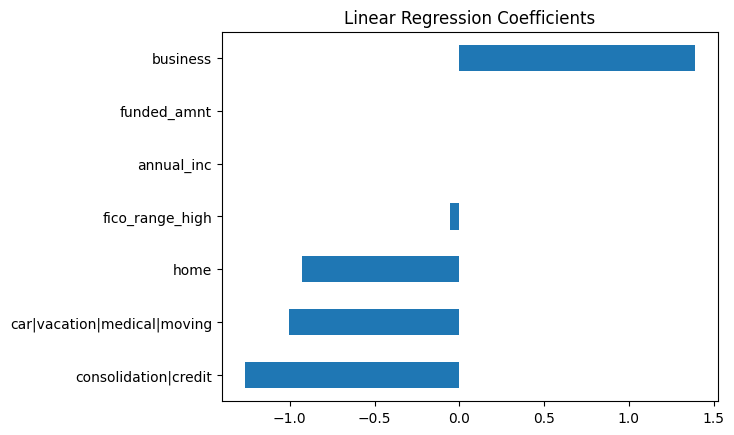

In [333]:
coefficients = model_lr.coef_
coef = pd.DataFrame(data=coefficients, index=X_train.columns,columns=['coefficients'])
coef['coefficients'].sort_values().plot(kind='barh');
plt.title('Linear Regression Coefficients')
plt.show()

In [334]:
model_lr.coef_

array([ 1.39280166e+00, -1.26666962e+00, -9.26304995e-01, -1.00538698e+00,
       -3.64983160e-06,  1.85564045e-05, -5.46767880e-02])

In [335]:
model_lr.intercept_

51.10122488917061

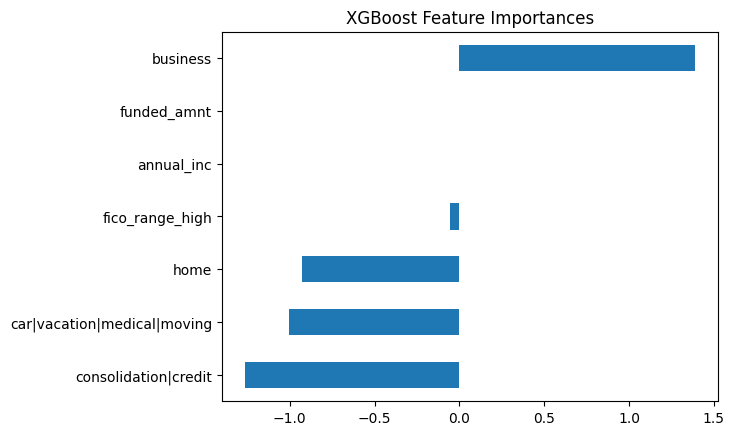

In [336]:
importances = model_r.coef_
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['coefficients'])
imp['coefficients'].sort_values().plot(kind='barh');
plt.title('XGBoost Feature Importances')
plt.show()

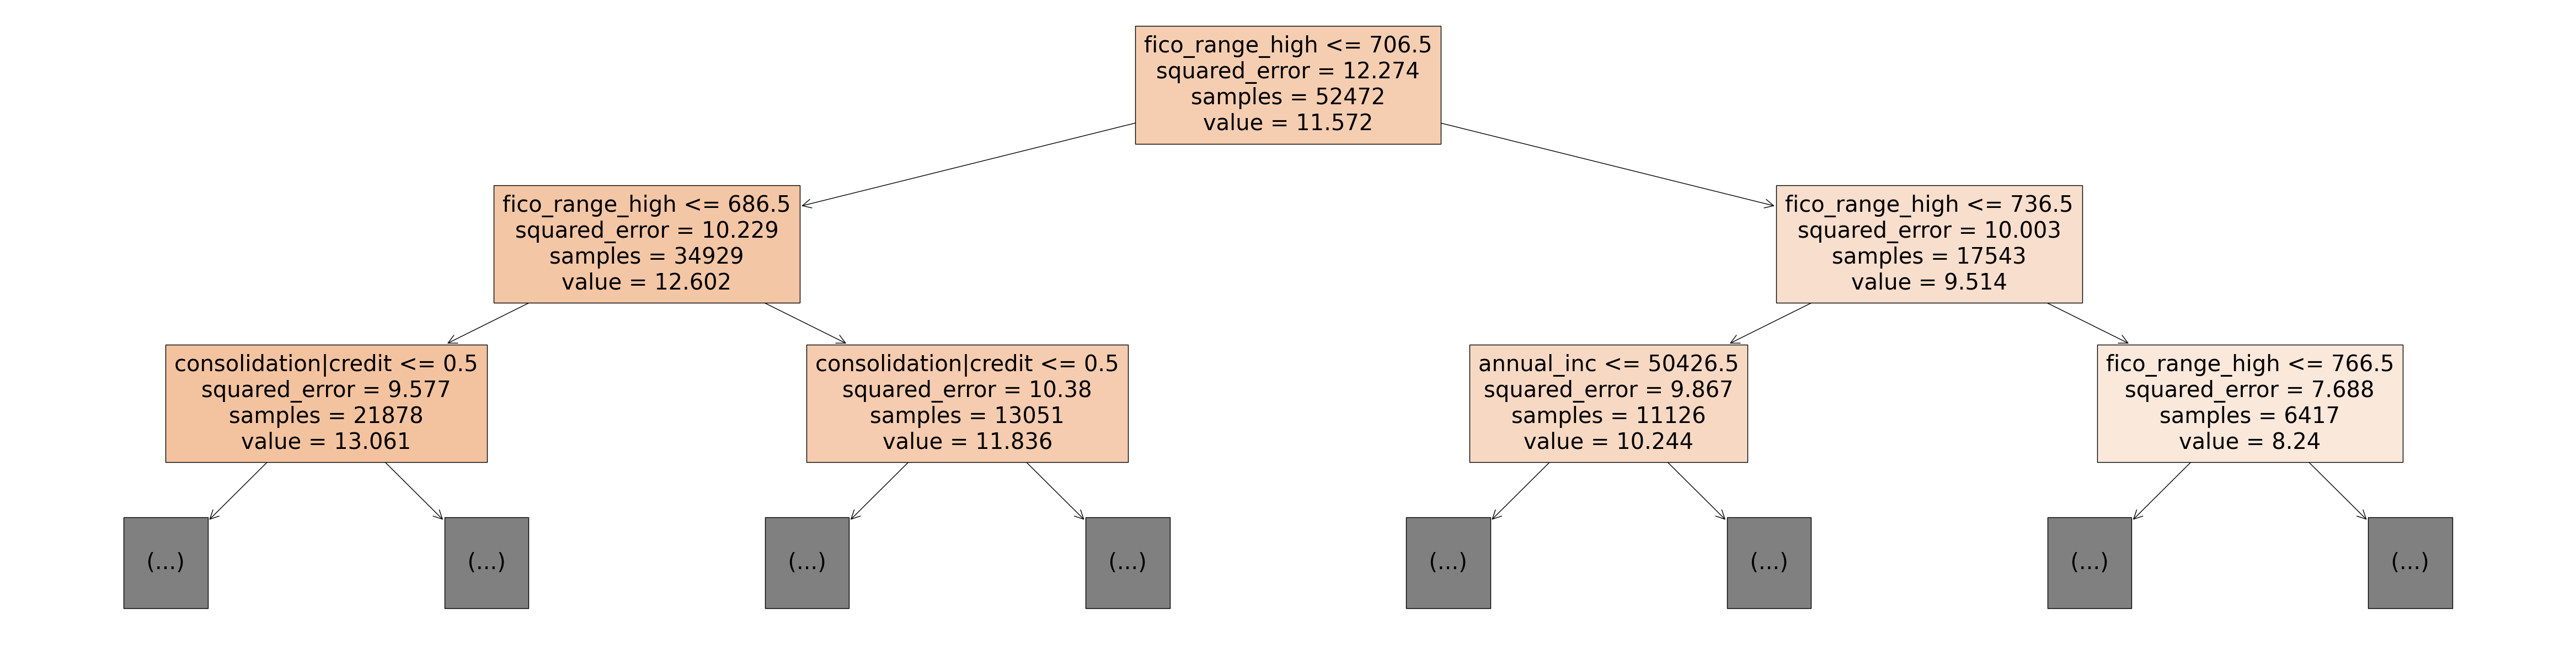

In [337]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,15))

plot_tree(
    model_rf.estimators_[0],
    max_depth=2,
    feature_names=X_train.columns,
    filled=True);

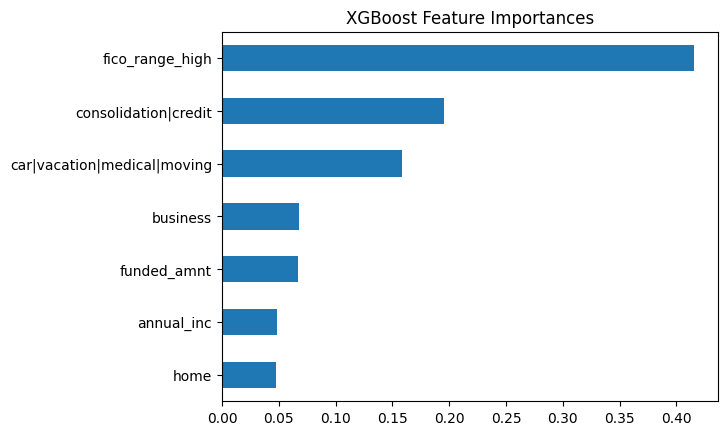

In [338]:
importances = model_xgb.feature_importances_
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['coefficients'])
imp['coefficients'].sort_values().plot(kind='barh');
plt.title('XGBoost Feature Importances')
plt.show()



# Build Partial Dependence Plot with PDPbox library

In [339]:
# insepct/test data
X_val

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,fico_range_high
issue_d,,,,,,,
2016-12-01,0,0,0,0,89000.0,4000.0,784.0
2016-12-01,0,1,0,0,56000.0,15000.0,714.0
2016-12-01,0,0,0,0,52000.0,10000.0,684.0
2016-12-01,0,1,0,0,52000.0,12000.0,689.0
2016-12-01,0,1,0,0,39000.0,6000.0,719.0
...,...,...,...,...,...,...,...
2017-08-01,0,1,0,0,32000.0,8000.0,734.0
2017-08-01,0,1,0,1,115000.0,4800.0,674.0
2017-08-01,0,1,0,0,48300.0,2000.0,679.0


In [340]:
# selecting one feature for the isolation
feature = 'annual_inc'

isolate = PDPIsolate(
    model=model_xgb,
    df=X_val,
    model_features=X_test.columns,
    feature=feature,
    feature_name=["Anual Income"],
    n_classes=0
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [341]:
# PDPbox uses graphs best with plotly
import plotly.io as pio

In [342]:
# Show a specific figure with plotly and the PDPbox library
# PDPIsolate.plot() retuns a tuple, so for this we're assinging it to a throw-away-varibale
fig, _ = isolate.plot()
pio.show(fig)

In [343]:
# get a look at the shape of the data...
pd.qcut(X['annual_inc'], q=10).value_counts()

(48000.0, 55000.0]       11317
(63000.0, 72000.0]       10683
(32000.0, 40000.0]       10622
(99900.0, 125000.0]      10608
(-0.001, 32000.0]        10514
(82500.0, 99900.0]       10262
(40000.0, 48000.0]       10009
(125000.0, 9300000.0]     9991
(55000.0, 63000.0]        9512
(72000.0, 82500.0]        9478
Name: annual_inc, dtype: int64

Two features

In [344]:
# selecting two features for the interaction analysis
interaction_features = ['annual_inc', 'fico_range_high']

interaction = PDPInteract(
    model_xgb,
    df=X_val,
    model_features=X.columns,
    features=interaction_features,
    feature_names=["Anual Income", "Credit Score"],
    n_classes=0
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

In [345]:
# create an instance of PDP Interact,
# retunred values are intrest rates as a percentage

fig2, _ = interaction.plot(plot_type='grid')
pio.show(fig2)

## Shapley Plots

In [346]:
# select one sample/observation
sample_row = X.tail(1)

In [347]:
# test/insepct our new data
sample_row

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,fico_range_high
issue_d,,,,,,,
2019-03-01,0,1,0,0,96000.0,5000.0,674.0


# Shapley Force Plot


In [348]:
# this will create a visualiation of all our detracters and suporters of the
explainer = shap.TreeExplainer(model_xgb)
shap_val = explainer.shap_values(sample_row)

# initialize java script:
shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values=shap_val,
    features=sample_row
)

